In [1]:
import pandas
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.impute 
import sklearn.preprocessing
from sklearn.preprocessing import OrdinalEncoder 


from sklearn.impute import SimpleImputer
%matplotlib inline

# Import data

In [2]:
data_train = pandas.read_csv('./Data/salary.train.csv', index_col='id')
data_test = pandas.read_csv('./Data/salary.test.csv', index_col='id')
data_live = pandas.read_csv('./Data/high_salary.live.csv', index_col='id')

---

	
# explore data

In [3]:
data_train.dtypes

social-security-number    float64
house-number              float64
age-group                 float64
workclass                  object
fnlwgt                    float64
education                  object
education-num             float64
marital-status             object
occupation                 object
relationship               object
race                       object
sex                        object
capitalgain               float64
capitalloss               float64
hoursperweek              float64
native-country-code        object
native-country             object
label                     float64
dtype: object

In [4]:
for feature in data_train:
    print(data_train[feature].value_counts())
    print('---------')

social-security-number
987463818.0    1
301692972.0    1
746670506.0    1
833224040.0    1
912989550.0    1
              ..
759703144.0    1
384262667.0    1
855279382.0    1
390891990.0    1
657404344.0    1
Name: count, Length: 16708, dtype: int64
---------
house-number
4668.0    8
6442.0    7
3096.0    7
5201.0    7
5439.0    7
         ..
8458.0    1
2556.0    1
7072.0    1
1512.0    1
8019.0    1
Name: count, Length: 8059, dtype: int64
---------
age-group
2.0    4515
1.0    4172
3.0    3310
0.0    2496
4.0    2220
Name: count, dtype: int64
---------
workclass
private             11278
self-emp-not-inc     1385
local-gov            1176
self-emp-inc          770
state-gov             707
federal-gov           547
without-pay             7
never-worked            3
Name: count, dtype: int64
---------
fnlwgt
148995.0    10
125892.0    10
164190.0     9
193882.0     9
111483.0     9
            ..
114011.0     1
191477.0     1
134639.0     1
268996.0     1
75065.0      1
Name: count,

From the previous analysis, we identified redundant and unique features to drop:
1. **Redundant Features** (keep one from each pair):
   - `education` or `education-num`
   - `native-country` or `native-country-code`

The Redundant features will be removed in a later step.

2. **Unique Features** (drop all):
   - `social-security-number`
   - `house-number`
   - `fnlwgt`

This will lead to no nominall data

In [5]:
data_train

,social-security-number,house-number,age-group,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country-code,native-country,label
id,,,,,,,,,,,,,,,,,,
26890,987463818.0,5066.0,3.0,state-gov,327886.0,doctorate,16.0,divorced,prof-specialty,own-child,white,male,0.0,0.0,3.0,USA,united-states,1.0
933,884327274.0,6423.0,3.0,private,99736.0,masters,14.0,divorced,prof-specialty,unmarried,white,male,4.0,0.0,3.0,USA,united-states,1.0
25596,397372044.0,9074.0,2.0,private,398575.0,some-college,10.0,never-married,tech-support,unmarried,white,female,0.0,0.0,2.0,USA,united-states,0.0
12949,580119132.0,413.0,2.0,private,682947.0,bachelors,13.0,divorced,exec-managerial,not-in-family,white,male,0.0,0.0,3.0,USA,united-states,1.0
6681,836161922.0,1790.0,1.0,private,236861.0,hs-grad,9.0,married-civ-spouse,machine-op-inspct,husband,white,male,0.0,0.0,2.0,USA,united-states,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,181655516.0,361.0,0.0,private,42706.0,some-college,10.0,never-married,prof-specialty,not-in-family,white,male,0.0,0.0,2.0,USA,united-states,0.0
2192,796404433.0,950.0,2.0,local-gov,103759.0,some-college,10.0,married-civ-spouse,transport-moving,husband,white,male,2.0,0.0,2.0,USA,united-states,0.0
8250,622635909.0,8689.0,0.0,private,316184.0,hs-grad,9.0,never-married,other-service,other-relative,black,male,0.0,0.0,2.0,USA,united-states,0.0


In [6]:
numeric_features = [
    'social-security-number',
    'house-number',
    'fnlwgt'
]
data_train = data_train.drop(columns=numeric_features)
data_test = data_test.drop(columns=numeric_features)
data_live = data_live.drop(columns=numeric_features)

In [7]:
data_train

,age-group,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country-code,native-country,label
id,,,,,,,,,,,,,,,
26890,3.0,state-gov,doctorate,16.0,divorced,prof-specialty,own-child,white,male,0.0,0.0,3.0,USA,united-states,1.0
933,3.0,private,masters,14.0,divorced,prof-specialty,unmarried,white,male,4.0,0.0,3.0,USA,united-states,1.0
25596,2.0,private,some-college,10.0,never-married,tech-support,unmarried,white,female,0.0,0.0,2.0,USA,united-states,0.0
12949,2.0,private,bachelors,13.0,divorced,exec-managerial,not-in-family,white,male,0.0,0.0,3.0,USA,united-states,1.0
6681,1.0,private,hs-grad,9.0,married-civ-spouse,machine-op-inspct,husband,white,male,0.0,0.0,2.0,USA,united-states,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,0.0,private,some-college,10.0,never-married,prof-specialty,not-in-family,white,male,0.0,0.0,2.0,USA,united-states,0.0
2192,2.0,local-gov,some-college,10.0,married-civ-spouse,transport-moving,husband,white,male,2.0,0.0,2.0,USA,united-states,0.0
8250,0.0,private,hs-grad,9.0,never-married,other-service,other-relative,black,male,0.0,0.0,2.0,USA,united-states,0.0


- define category

---

# Missing value

### Detect missing value

In [8]:

categorical_features = [
    'age-group',
    'education',
    'education-num',
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country-code',
    'native-country',
    'capitalgain',  
    'capitalloss',  
    'hoursperweek' 
]

- Training Data

In [9]:
data_train_numeric = data_train[categorical_features]
data_train_numeric.isna().sum()

age-group                7
education               16
education-num           12
workclass              847
marital-status          21
occupation             845
relationship            15
race                    14
sex                     15
native-country-code    322
native-country         323
capitalgain             20
capitalloss             14
hoursperweek            19
dtype: int64

- Testing Data

In [10]:
data_test_numeric = data_test[categorical_features]
data_test_numeric.isna().sum()

age-group                6
education                4
education-num            2
workclass              210
marital-status           2
occupation             209
relationship             6
race                     8
sex                      7
native-country-code     77
native-country          75
capitalgain              3
capitalloss              7
hoursperweek             2
dtype: int64

- Live data

In [11]:
data_live_numeric = data_live[categorical_features]
data_live_numeric.isna().sum()

age-group               13
education                7
education-num            8
workclass              345
marital-status           9
occupation             347
relationship            13
race                     7
sex                      7
native-country-code    122
native-country         123
capitalgain              8
capitalloss             10
hoursperweek            13
dtype: int64

### Handle missing value 

In [12]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer

SimpleImputer(strategy='most_frequent')

In [13]:
data_train_categorical_features = data_train[categorical_features]
data_test_categorical_features = data_test[categorical_features]
data_live_categorical_features = data_live[categorical_features]

- Data train

In [14]:
categorical_imputer.fit(data_train_categorical_features)
data_train_categorical_features = pandas.DataFrame(
    data = categorical_imputer.transform(data_train_categorical_features),
    columns = categorical_imputer.get_feature_names_out(),
    index =data_train_categorical_features.index
)
data_train_categorical_features.isna().sum(axis='index')

age-group              0
education              0
education-num          0
workclass              0
marital-status         0
occupation             0
relationship           0
race                   0
sex                    0
native-country-code    0
native-country         0
capitalgain            0
capitalloss            0
hoursperweek           0
dtype: int64

- Data test

In [15]:
categorical_imputer.fit(data_test_categorical_features)
data_test_categorical_features = pandas.DataFrame(
    data = categorical_imputer.transform(data_test_categorical_features),
    columns = categorical_imputer.get_feature_names_out(),
    index =data_test_categorical_features.index
)
data_test_categorical_features.isna().sum(axis='index')

age-group              0
education              0
education-num          0
workclass              0
marital-status         0
occupation             0
relationship           0
race                   0
sex                    0
native-country-code    0
native-country         0
capitalgain            0
capitalloss            0
hoursperweek           0
dtype: int64

- Live

In [16]:
categorical_imputer.fit(data_live_categorical_features)
data_live_categorical_features = pandas.DataFrame(
    data = categorical_imputer.transform(data_live_categorical_features),
    columns = categorical_imputer.get_feature_names_out(),
    index =data_live_categorical_features.index
)
data_live_categorical_features.isna().sum(axis='index')

age-group              0
education              0
education-num          0
workclass              0
marital-status         0
occupation             0
relationship           0
race                   0
sex                    0
native-country-code    0
native-country         0
capitalgain            0
capitalloss            0
hoursperweek           0
dtype: int64

### Reconstruction of imputed features

In [17]:
data_train = (
    data_train_categorical_features
    .join(data_train['label'])
)
data_test = (
    data_test_categorical_features
    .join(data_test['label'])
)
data_live = (
    data_live_categorical_features
)

In [18]:
print('Columns:', data_train.columns.size, end='')
print(data_train.dtypes)

Columns: 15age-group               object
education               object
education-num           object
workclass               object
marital-status          object
occupation              object
relationship            object
race                    object
sex                     object
native-country-code     object
native-country          object
capitalgain             object
capitalloss             object
hoursperweek            object
label                  float64
dtype: object


In [19]:
print('Columns:', data_test.columns.size, end='')
print(data_test.dtypes)

Columns: 15age-group               object
education               object
education-num           object
workclass               object
marital-status          object
occupation              object
relationship            object
race                    object
sex                     object
native-country-code     object
native-country          object
capitalgain             object
capitalloss             object
hoursperweek            object
label                  float64
dtype: object


In [20]:
print('Columns:', data_live.columns.size, end='')
print(data_live.dtypes)

Columns: 14age-group              object
education              object
education-num          object
workclass              object
marital-status         object
occupation             object
relationship           object
race                   object
sex                    object
native-country-code    object
native-country         object
capitalgain            object
capitalloss            object
hoursperweek           object
dtype: object


## Encoding

### Ordinal encoding (if need)

**Redundant Features** (keep one from each pair):
   - `education` or `education-num`
   - `native-country` or `native-country-code`

In [21]:
ordinal_features = ['age-group', 'education', 'education-num','capitalgain', 'capitalloss', 'hoursperweek']

In [22]:
for feature in ordinal_features:
    possible_values = data_train[feature].unique()
    print(f"{feature:20s} {possible_values.size:2d} {possible_values}")

age-group             5 [3.0 2.0 1.0 0.0 4.0]
education            16 ['doctorate' 'masters' 'some-college' 'bachelors' 'hs-grad' 'assoc-voc'
 '12th' 'prof-school' '7th-8th' '11th' '10th' 'assoc-acdm' '9th' '5th-6th'
 '1st-4th' 'preschool']
education-num        16 [16.0 14.0 10.0 13.0 9.0 11.0 8.0 15.0 4.0 7.0 6.0 12.0 5.0 3.0 2.0 1.0]
capitalgain           5 [0.0 4.0 3.0 2.0 1.0]
capitalloss           5 [0.0 3.0 2.0 1.0 4.0]
hoursperweek          5 [3.0 2.0 0.0 1.0 4.0]


- we'd drop `education` to becuase we have an encoded version already(`education-num`)

In [23]:
data_train = data_train.drop(columns=['education'])
data_test = data_test.drop(columns=['education'])   
data_live = data_live.drop(columns=['education'])   

- Update `ordinal_feture`

In [24]:
ordinal_features = ['age-group', 'education-num','capitalgain', 'capitalloss', 'hoursperweek']

In [25]:
print(data_train[ordinal_features])
print('--------------------------')
print(data_test[ordinal_features])
print('--------------------------')
print(data_live[ordinal_features])

      age-group education-num capitalgain capitalloss hoursperweek
id                                                                
26890       3.0          16.0         0.0         0.0          3.0
933         3.0          14.0         4.0         0.0          3.0
25596       2.0          10.0         0.0         0.0          2.0
12949       2.0          13.0         0.0         0.0          3.0
6681        1.0           9.0         0.0         0.0          2.0
...         ...           ...         ...         ...          ...
8695        0.0          10.0         0.0         0.0          2.0
2192        2.0          10.0         2.0         0.0          2.0
8250        0.0           9.0         0.0         0.0          2.0
18511       2.0          14.0         0.0         0.0          0.0
16074       2.0           8.0         0.0         0.0          3.0

[16720 rows x 5 columns]
--------------------------
      age-group education-num capitalgain capitalloss hoursperweek
id       

As it show from the top cell all features in the dataset have already been encoded.

### Onehot encoding for nominal features

In [26]:
nominal_features = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country-code',
    'native-country',
]

In [27]:
for feature in nominal_features:
    possible_values = data_train[feature].unique()
    print(f"{feature:20s} {possible_values.size:2d} {possible_values}")

workclass             8 ['state-gov' 'private' 'self-emp-inc' 'self-emp-not-inc' 'federal-gov'
 'local-gov' 'without-pay' 'never-worked']
marital-status        7 ['divorced' 'never-married' 'married-civ-spouse' 'separated' 'widowed'
 'married-spouse-absent' 'married-af-spouse']
occupation           14 ['prof-specialty' 'tech-support' 'exec-managerial' 'machine-op-inspct'
 'sales' 'handlers-cleaners' 'craft-repair' 'other-service' 'adm-clerical'
 'transport-moving' 'protective-serv' 'farming-fishing' 'priv-house-serv'
 'armed-forces']
relationship          6 ['own-child' 'unmarried' 'not-in-family' 'husband' 'wife' 'other-relative']
race                  5 ['white' 'black' 'asian-pac-islander' 'other' 'amer-indian-eskimo']
sex                   2 ['male' 'female']
native-country-code  40 ['USA' 'HTI' 'GRC' 'ZAF' 'IND' 'CHN' 'LAO' 'JPN' 'PHL' 'COL' 'VNM' 'PRI'
 'YUG' 'CUB' 'DUE' 'ITA' 'TWN' 'SLV' 'JAM' 'CAN' 'MEX' 'PRT' 'IRN' 'GBR'
 'POL' 'GTM' 'KHM' 'PER' 'ECU' 'DOM' 'HUN' 'TTO' 'IRL' '

We cannot use normal encoding in to `native-country, capitalgain`, its will make the model mor complicated (many collumns will be create)  
and We should drop `native-country-code` becuase its redundant

In [28]:
data_train = data_train.drop(columns=['native-country-code'])
data_test = data_test.drop(columns=['native-country-code'])   
data_live = data_live.drop(columns=['native-country-code'])   

- use normal encoding

In [29]:
normal_nominal_features = [
    'occupation',
    'workclass',
    'marital-status',
    'relationship',
    'race',
    'sex',
]

In [30]:
for feature in normal_nominal_features:
    possible_values = data_train[feature].unique()
    print(f"{feature:20s} {possible_values.size:2d} {possible_values}")

occupation           14 ['prof-specialty' 'tech-support' 'exec-managerial' 'machine-op-inspct'
 'sales' 'handlers-cleaners' 'craft-repair' 'other-service' 'adm-clerical'
 'transport-moving' 'protective-serv' 'farming-fishing' 'priv-house-serv'
 'armed-forces']
workclass             8 ['state-gov' 'private' 'self-emp-inc' 'self-emp-not-inc' 'federal-gov'
 'local-gov' 'without-pay' 'never-worked']
marital-status        7 ['divorced' 'never-married' 'married-civ-spouse' 'separated' 'widowed'
 'married-spouse-absent' 'married-af-spouse']
relationship          6 ['own-child' 'unmarried' 'not-in-family' 'husband' 'wife' 'other-relative']
race                  5 ['white' 'black' 'asian-pac-islander' 'other' 'amer-indian-eskimo']
sex                   2 ['male' 'female']


In [31]:
nominal_categories = [
    ['prof-specialty', 'tech-support', 'exec-managerial', 'machine-op-inspct',
     'sales', 'handlers-cleaners', 'craft-repair', 'other-service', 'adm-clerical',
     'transport-moving', 'protective-serv', 'farming-fishing', 'priv-house-serv',
     'armed-forces'],
     ['state-gov', 'private', 'self-emp-inc', 'self-emp-not-inc', 'federal-gov',
      'local-gov', 'without-pay', 'never-worked'],
      ['divorced', 'never-married', 'married-civ-spouse', 'separated', 'widowed',
       'married-spouse-absent', 'married-af-spouse'],
    ['not-in-family', 'husband', 'other-relative', 'wife', 'own-child', 'unmarried'],  # relationship
    ['white', 'amer-indian-eskimo', 'black', 'asian-pac-islander', 'other'],  # race
    ['male', 'female'],  # sex
]

In [32]:
onehot_encoder = sklearn.preprocessing.OneHotEncoder(categories=nominal_categories, sparse_output=False, handle_unknown='ignore')
onehot_encoder.fit(
    X=data_train[normal_nominal_features]
)

OneHotEncoder(categories=[['prof-specialty', 'tech-support', 'exec-managerial',
                           'machine-op-inspct', 'sales', 'handlers-cleaners',
                           'craft-repair', 'other-service', 'adm-clerical',
                           'transport-moving', 'protective-serv',
                           'farming-fishing', 'priv-house-serv',
                           'armed-forces'],
                          ['state-gov', 'private', 'self-emp-inc',
                           'self-emp-not-inc', 'federal-gov', 'local-gov',
                           'without-pay', 'never-worked'],
                          ['divorced', 'never-married', 'married-civ-spouse',
                           'separated', 'widowed', 'married-spouse-absent',
                           'married-af-spouse'],
                          ['not-in-family', 'husband', 'other-relative', 'wife',
                           'own-child', 'unmarried'],
                          ['white', 'amer-indian-eskimo', 'black',
                           'asian-pac-islander', 'other'],
                          ['male', 'female']],
              handle_unknown='ignore', sparse_output=False)

- Fit to all data

In [33]:
data_train_normal_nominal_features = pandas.DataFrame(
    data    = onehot_encoder.transform(data_train[normal_nominal_features]),
    columns = onehot_encoder.get_feature_names_out(),
    index   = data_train.index
)
data_test_normal_nominal_features = pandas.DataFrame(
    data    = onehot_encoder.transform(data_test[normal_nominal_features]),
    columns = onehot_encoder.get_feature_names_out(),
    index   = data_test.index
)
data_live_normal_nominal_features = pandas.DataFrame(
    data    = onehot_encoder.transform(data_live[normal_nominal_features]),
    columns = onehot_encoder.get_feature_names_out(),
    index   = data_live.index
)
data_train_normal_nominal_features

,occupation_prof-specialty,occupation_tech-support,occupation_exec-managerial,occupation_machine-op-inspct,occupation_sales,occupation_handlers-cleaners,occupation_craft-repair,occupation_other-service,occupation_adm-clerical,occupation_transport-moving,...,relationship_wife,relationship_own-child,relationship_unmarried,race_white,race_amer-indian-eskimo,race_black,race_asian-pac-islander,race_other,sex_male,sex_female
id,,,,,,,,,,,,,,,,,,,,,
26890,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
933,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25596,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12949,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6681,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


- Reconstruction

In [34]:
data_train = data_train.drop(columns=normal_nominal_features)
data_test = data_test.drop(columns=normal_nominal_features)
data_live = data_live.drop(columns=normal_nominal_features)

In [35]:
data_train =(
    data_train
    .join(data_train_normal_nominal_features)
    
)
data_train = data_train[[col for col in data_train.columns if col != 'label'] + ['label']]
data_test =(
    data_test
    .join(data_test_normal_nominal_features)
   
)
data_test = data_test[[col for col in data_test.columns if col != 'label'] + ['label']]
data_live =(
    data_live
    .join(data_live_normal_nominal_features)
)

In [36]:
data_train

,age-group,education-num,native-country,capitalgain,capitalloss,hoursperweek,occupation_prof-specialty,occupation_tech-support,occupation_exec-managerial,occupation_machine-op-inspct,...,relationship_own-child,relationship_unmarried,race_white,race_amer-indian-eskimo,race_black,race_asian-pac-islander,race_other,sex_male,sex_female,label
id,,,,,,,,,,,,,,,,,,,,,
26890,3.0,16.0,united-states,0.0,0.0,3.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
933,3.0,14.0,united-states,4.0,0.0,3.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25596,2.0,10.0,united-states,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12949,2.0,13.0,united-states,0.0,0.0,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6681,1.0,9.0,united-states,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,0.0,10.0,united-states,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2192,2.0,10.0,united-states,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8250,0.0,9.0,united-states,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Use Lumping Categories for `native-country`

- Find the top value of this feature

In [37]:
top_5_countries = data_train['native-country'].value_counts().index[:5]
print("Top 5 countries:", top_5_countries)

Top 5 countries: Index(['united-states', 'mexico', 'philippines', 'germany', 'canada'], dtype='object', name='native-country')


- Apply to all data

In [38]:
data_train['native-country'] = np.where(
    data_train['native-country'].isin(top_5_countries), 
    data_train['native-country'], 
    'Other'
)

data_test['native-country'] = np.where(
    data_test['native-country'].isin(top_5_countries), 
    data_test['native-country'], 
    'Other'
)

data_live['native-country'] = np.where(
    data_live['native-country'].isin(top_5_countries), 
    data_live['native-country'], 
    'Other'
)
print('Native country in data_train :', data_train['native-country'].unique())
print('Native country in data_test :', data_test['native-country'].unique())
print('Native country in data_live :', data_live['native-country'].unique())


Native country in data_train : ['united-states' 'Other' 'philippines' 'germany' 'canada' 'mexico']
Native country in data_test : ['united-states' 'mexico' 'Other' 'canada' 'germany' 'philippines']
Native country in data_live : ['united-states' 'mexico' 'philippines' 'Other' 'canada' 'germany']


***Using label encoder***
    
- This learns all the unique categories (e.g., 'united-states' -> 5, 'mexico' -> 2, etc.)

In [39]:
from sklearn.preprocessing import LabelEncoder


In [40]:
country_encoder = LabelEncoder()

- Fit to train_data

In [41]:
# 2. FIT the encoder *ONLY* on the training data.
# This learns all the unique categories (e.g., 'united-states' -> 5, 'mexico' -> 2, etc.)
country_encoder.fit(data_train['native-country'])

LabelEncoder()

- Apply to all data

In [42]:
data_train['native-country_encoded'] = country_encoder.transform(data_train['native-country'])
data_train['native-country'] = data_train['native-country_encoded']
data_train = data_train.drop(columns = ['native-country_encoded'])
data_train['native-country'].unique()

array([5, 0, 4, 2, 1, 3])

In [43]:
data_test['native-country_encoded'] = country_encoder.transform(data_test['native-country'])
data_test['native-country'] = data_test['native-country_encoded']
data_test =data_test.drop(columns = ['native-country_encoded'])
data_test['native-country'].unique()

array([5, 3, 0, 1, 2, 4])

In [44]:
data_live['native-country_encoded'] = country_encoder.transform(data_live['native-country'])
data_live['native-country'] = data_live['native-country_encoded']
data_live =data_live.drop(columns = ['native-country_encoded'])
data_live['native-country'].unique()

array([5, 3, 4, 0, 1, 2])

---

## Save all file


In [45]:
data_train.to_csv('./data/salary.train.processed.csv')
data_test.to_csv('./data/salary.test.processed.csv')
data_live.to_csv('./data/salary.live.processed.csv')

print("Successfully saved all 3 processed files to the './data/' folder.")

Successfully saved all 3 processed files to the './data/' folder.


---

## Feature selection

Compute correlation with the target

In [46]:
import pandas as pd

# Example: assuming data_train is your processed dataset
X = data_train.drop(columns=['label'])
y = data_train['label']


In [47]:
# Compute correlation with the target
corr_with_label = X.corrwith(y).abs().sort_values(ascending=False)

print("Top correlated features with label:")
print(corr_with_label.head(10))

Top correlated features with label:
marital-status_married-civ-spouse    0.509334
relationship_husband                 0.450938
marital-status_never-married         0.385850
education-num                        0.373260
capitalgain                          0.310260
age-group                            0.293202
relationship_own-child               0.286117
hoursperweek                         0.276753
sex_male                             0.254890
sex_female                           0.254890
dtype: float64


In [48]:
threshold = 0.1
selected_features = corr_with_label[corr_with_label >= threshold].index.tolist()


In [49]:
X_selected = X[selected_features]
print(f"Selected {len(selected_features)} features based on correlation >= {threshold}")


Selected 24 features based on correlation >= 0.1


In [50]:
corr_matrix = X_selected.corr().abs()

# Create upper triangle mask
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))

# Drop features with high inter-correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

X_final = X_selected.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} redundant features.")


Dropped 1 redundant features.


In [51]:
data_selected = pd.concat([X_final, y], axis=1)


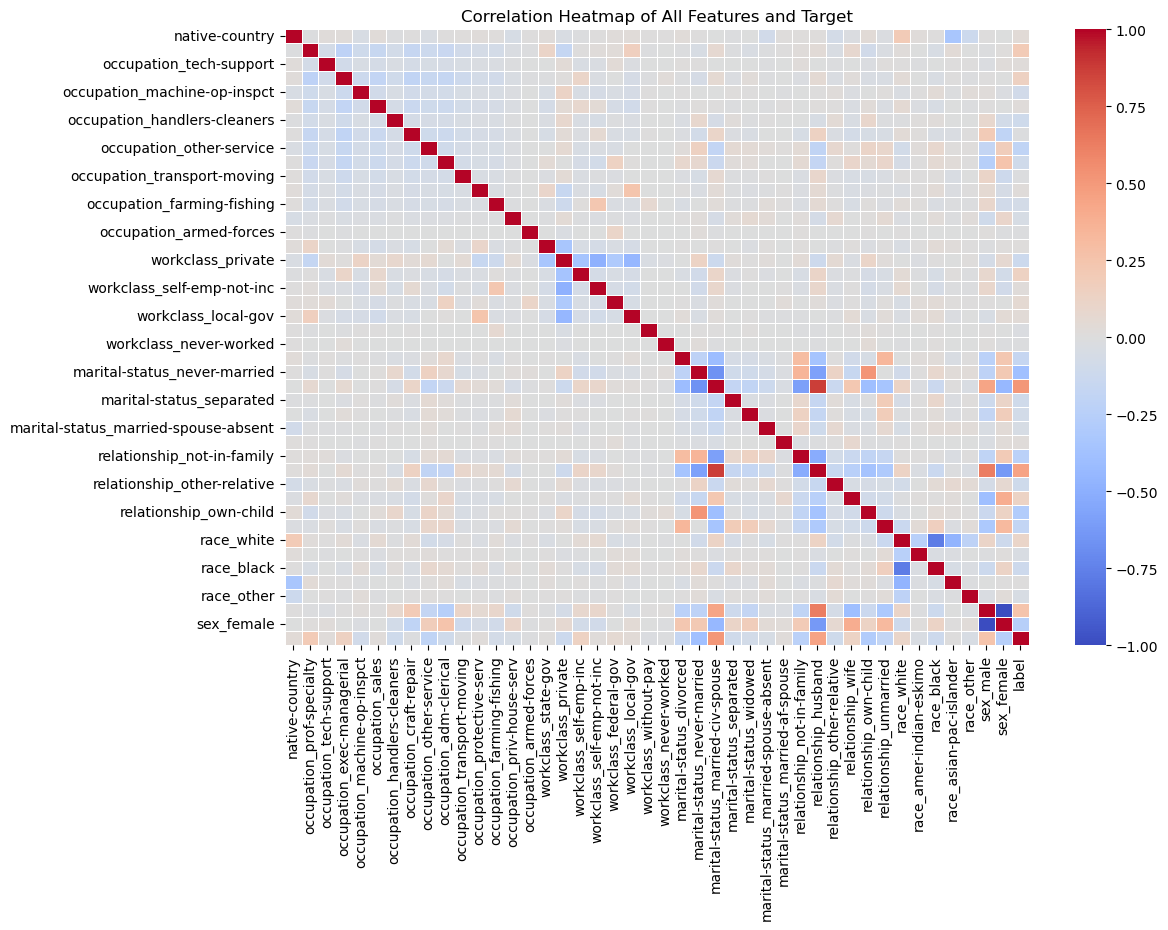

In [52]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

# คำนวณ correlation matrix (เฉพาะ numeric features)
corr_matrix = data_train.corr(numeric_only=True)

# สร้าง heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=False,  # ไม่แสดงตัวเลขบน heatmap
    cmap='coolwarm',
    center=0,
    linewidths=0.5,  # ความหนาของเส้นแบ่ง
    linecolor='white'  # สีของเส้นแบ่ง
)
plt.title("Correlation Heatmap of All Features and Target")
plt.show()



In [53]:
print(selected_features)

['marital-status_married-civ-spouse', 'relationship_husband', 'marital-status_never-married', 'education-num', 'capitalgain', 'age-group', 'relationship_own-child', 'hoursperweek', 'sex_male', 'sex_female', 'relationship_not-in-family', 'occupation_prof-specialty', 'occupation_other-service', 'relationship_unmarried', 'marital-status_divorced', 'capitalloss', 'occupation_exec-managerial', 'workclass_self-emp-inc', 'relationship_wife', 'workclass_private', 'race_black', 'race_white', 'relationship_other-relative', 'occupation_handlers-cleaners']


---

In [56]:
data_train.dtypes

age-group                                object
education-num                            object
native-country                            int32
capitalgain                              object
capitalloss                              object
hoursperweek                             object
occupation_prof-specialty               float64
occupation_tech-support                 float64
occupation_exec-managerial              float64
occupation_machine-op-inspct            float64
occupation_sales                        float64
occupation_handlers-cleaners            float64
occupation_craft-repair                 float64
occupation_other-service                float64
occupation_adm-clerical                 float64
occupation_transport-moving             float64
occupation_protective-serv              float64
occupation_farming-fishing              float64
occupation_priv-house-serv              float64
occupation_armed-forces                 float64
workclass_state-gov                     